In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 2
num_attr_vals = 8
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 64 unqiue cards
Generated 2016 cardpairs
-- 448 cardpairs with shared concept
-- 1568 cardpairs without shared concept
[(0, 1568), (1, 448)]
Total number of matches =  3584
Number of shared concepts per match =  [(1, 3584)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1e-100, 125440), (0.00027901785714285713, 3584)]

In [5]:
np.sum(count_table)

3584.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 15
xy_div_xyind_rank= 15


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

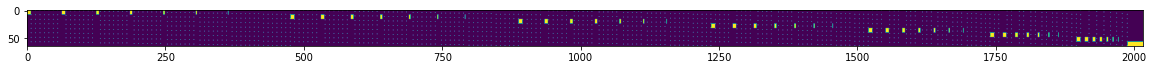

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

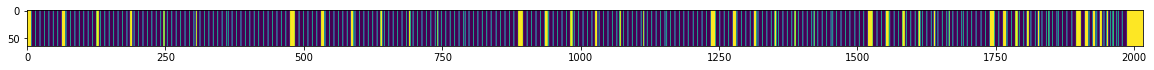

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

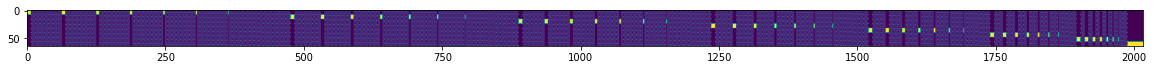

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

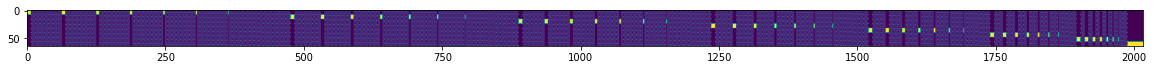

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [12]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.9999999999999988, 64288),
 (0.9999999999999986, 21952),
 (2.8672000000000013e-96, 19600),
 (0.9999999999999989, 14112),
 (2.867200000000001e-96, 5488),
 (8.000000000000004, 2800),
 (8.000000000000002, 784)]

## Dataset

In [13]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('green', 'checkered')
key
 0 ('red', 'void')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'void')
key
 0 ('red', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue', 'void'), ('orange', 'void'), ('cyan', 'void'), ('magenta', 'void'), ('black', 'void'), ('yellow', 'void')]


(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))

In [14]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('green', 'checkered')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue', 'void'), ('orange', 'void'), ('cyan', 'void'), ('magenta', 'void'), ('black', 'void'), ('yellow', 'void')]


(7,
 tensor([7]),
 tensor([-9223372036854775808]),
 tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))

In [15]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [16]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # classifier
    if hparams['classifier_nonlinearity'] == 'ReLU':
        classifier_non_linearity = nn.ReLU
    elif hparams['classifier_nonlinearity'] == 'Sigmoid':
        classifier_non_linearity = nn.Sigmoid
    else:
        raise ValueError('Unaccepted choice of nonlinearity')
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict(
                make_classifier(
                    scale_down_factor=hparams['classifier_layer_scaledown_factor'], 
                    d_model=hparams['d_model'],
                    non_linearity_class = classifier_non_linearity,
                )
            )
        ) if not hparams['dotproduct_bottleneck'] else None, 
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [17]:
def make_classifier(scale_down_factor, d_model, non_linearity_class):
    '''
    scale_down_factor: list e.g. [2,2,4]
    '''
    layer_lst = []
    last_dim = 2*d_model
    for i in range(len(scale_down_factor)):
        new_dim = int(2*d_model / scale_down_factor[i])
        layer_lst.append(('linear{}'.format(i), nn.Linear(last_dim, new_dim)))
        layer_lst.append(('Nonlinear{}'.format(i), non_linearity_class()))
        last_dim = new_dim
    layer_lst.append(('linear-out', nn.Linear(last_dim, 1)))
    
    return layer_lst

make_classifier([2,2,4], 48, nn.ReLU)

[('linear0', Linear(in_features=96, out_features=48, bias=True)),
 ('Nonlinear0', ReLU()),
 ('linear1', Linear(in_features=48, out_features=48, bias=True)),
 ('Nonlinear1', ReLU()),
 ('linear2', Linear(in_features=48, out_features=24, bias=True)),
 ('Nonlinear2', ReLU()),
 ('linear-out', Linear(in_features=24, out_features=1, bias=True))]

In [18]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [19]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        print(classifier)
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [20]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [21]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [22]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [23]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # classifier
    'classifier_nonlinearity': 'ReLU', # ReLU, Sigmoid
    'classifier_layer_scaledown_factor': [1,2], 
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 32,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':False,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;{}{}ClassifierLayers'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2), str(hparams['classifier_layer_scaledown_factor']), hparams['classifier_nonlinearity'])
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


Sequential(
  (linear0): Linear(in_features=64, out_features=64, bias=True)
  (Nonlinear0): ReLU()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (Nonlinear1): ReLU()
  (linear-out): Linear(in_features=32, out_features=1, bias=True)
)
   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 72.8 K
1  | model.inp_query_layer                        | Sequential         | 64.5 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 64.5 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 64.5 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 2.0 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 2.0 K 
7  | model.inp_key_l

## Run Training

In [ ]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[0], 
    min_epochs=2, max_epochs=15000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-24-86fefc262d20>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


wandb: WARNING Serializing object of type ndarray that is 1032304 bytes
wandb: WARNING Serializing object of type ndarray that is 1032304 bytes

   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 72.8 K
1  | model.inp_query_layer                        | Sequential         | 64.5 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 64.5 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 64.5 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 2.0 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 2.0 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 2.0 K 
8  | model.classifier                            

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                        

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=621, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=621, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=621, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=621, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=621, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=621, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=621, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=621, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=621, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/

Epoch 34:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=621, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=621, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=620, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=620, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=620, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=620, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=620, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=620, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=620, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|████

Validating: 0it [00:00, ?it/s]
Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=619, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=619, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=619, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=619, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=619, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=619, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 74:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=619, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 75:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=619, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 76:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=619, v_num=u8iy]
Validating: 0it [00

Epoch 101:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=614, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 102:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=614, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 103:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=614, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 104:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=614, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 105:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=613, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 106:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=613, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 107:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=612, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 108:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=612, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 109:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=612, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 110:

Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=589, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=588, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=587, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 138:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=586, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 139:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=584, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 140:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=583, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 141:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=581, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 142:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=579, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 143:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=578, v_num=u8iy]
Validating

Epoch 168:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=529, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 169:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=527, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 170:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=524, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 171:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=522, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 172:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=519, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 173:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=518, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 174:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=516, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 175:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=515, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 176:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=513, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 177:

Epoch 201:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=484, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 202:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=482, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 203:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=479, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 204:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=478, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 205:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=477, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 206:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=475, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 207:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=474, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 208:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=474, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 209:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=473, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 210:

Validating: 0it [00:00, ?it/s]
Epoch 235:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=444, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 236:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=445, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 237:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=444, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 238:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=443, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 239:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=442, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 240:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=440, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 241:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=438, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 242:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=437, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 243:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=436, v_num=u8iy]
Validating

Epoch 268:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=422, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 269:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=420, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 270:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=419, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 271:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=418, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 272:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=418, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 273:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=417, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 274:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=417, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 275:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=417, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 276:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=417, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 277:

Epoch 301:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=403, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 302:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=403, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 303:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=402, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 304:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=402, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 305:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=402, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 306:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=400, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 307:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=399, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 308:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=400, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 309:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=399, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 310:

Epoch 335:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=393, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 336:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=393, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 337:  50%|█████     | 1/2 [00:00<00:00,  2.98it/s, loss=393, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 338:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=392, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 339:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=392, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 340:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=391, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 341:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=390, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 342:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=390, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=389, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 344:

Epoch 368:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=386, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 369:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=386, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 370:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=385, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 371:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=385, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 372:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=385, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 373:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=384, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 374:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=384, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 375:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=383, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 376:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=383, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 377:

Epoch 401:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=380, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 402:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=380, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 403:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=380, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 404:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=380, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 405:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=380, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 406:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=380, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 407:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=380, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 408:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=380, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 409:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=380, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 410:

Validating: 0it [00:00, ?it/s]
Epoch 435:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=377, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 436:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=377, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 437:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=376, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 438:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=377, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 439:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=377, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 440:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=377, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 441:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=377, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 442:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=376, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 443:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=376, v_num=u8iy]
Validating

Epoch 468:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=376, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 469:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=376, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 470:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=376, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|█████     | 1/2 [00:00<00:00,  2.59it/s, loss=376, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=376, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=376, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=376, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 475:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=376, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 476:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=376, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 477:

Epoch 501:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=374, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 502:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=374, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 503:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=374, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 504:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=374, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 505:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=374, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 506:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=373, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 507:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=373, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 508:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=374, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 509:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=373, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 510:

Validating: 0it [00:00, ?it/s]
Epoch 535:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=372, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 536:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=372, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 537:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=372, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 538:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=372, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 539:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=372, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 540:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=372, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 541:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=372, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 542:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=372, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 543:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=371, v_num=u8iy]
Validating

Epoch 568:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 569:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 570:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 571:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=368, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 572:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 573:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 574:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 575:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 576:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 577:

Epoch 601:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 602:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 603:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 604:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 605:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=370, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 606:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=370, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 607:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=370, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 608:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 609:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=370, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 610:

Validating: 0it [00:00, ?it/s]
Epoch 635:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=368, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 636:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=368, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 637:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=368, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 638:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=368, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 639:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=368, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 640:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 641:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 643:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=367, v_num=u8iy]
Validating

Epoch 668:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=368, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 669:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 670:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 671:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 672:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 673:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=368, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 674:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 675:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=368, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 676:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=369, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 677:

Epoch 701:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=366, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 702:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=366, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 703:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 704:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 705:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 706:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 707:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 708:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 709:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 710:

Validating: 0it [00:00, ?it/s]
Epoch 735:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=366, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 736:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=366, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 737:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 738:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 739:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 740:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 741:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 742:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=365, v_num=u8iy]
Validating

Epoch 768:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 769:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 770:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 771:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 772:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 773:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 774:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=368, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 775:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 776:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=367, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 777:

Epoch 801:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 802:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 803:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 804:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 805:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 806:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 810:

Validating: 0it [00:00, ?it/s]
Epoch 835:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 836:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 837:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 838:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 839:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 840:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 841:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 842:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=366, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 843:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=366, v_num=u8iy]
Validating

Epoch 868:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 869:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 870:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 871:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 872:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 873:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 874:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 875:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 876:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 877:

Epoch 901:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 902:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 903:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 904:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 905:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 906:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 907:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 908:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 909:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 910:

Validating: 0it [00:00, ?it/s]
Epoch 935:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 936:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 937:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=363, v_num=u8iy]
Validating

Epoch 968:  50%|█████     | 1/2 [00:00<00:00,  2.86it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 969:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 970:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 971:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 972:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 973:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 974:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 975:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=364, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 976:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=365, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 977:

Epoch 1001:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1002:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1003:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1004:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1005:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1006:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1007:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1008:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1009:  50%|█████     | 1/2 [00:00<00:00,  2.60it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1034:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1035:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1036:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1037:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1038:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1039:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1040:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1041:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1042:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1067:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1070:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1071:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1072:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1073:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1074:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1075:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1100:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1101:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1102:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1103:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1104:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1105:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1106:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1107:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1108:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1133:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1134:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1135:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1136:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1137:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1138:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1139:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1140:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1141:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1166:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1167:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1168:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1169:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1170:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1171:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1172:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1173:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1174:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=363, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1199: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1200:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1201:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1202:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1203:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1204:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1205:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1206:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1207:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1232:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1233:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1234:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1235:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1236:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1237:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1238:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1239:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1240:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1265:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1266:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1267:  50%|█████     | 1/2 [00:00<00:00,  2.53it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1268:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1269:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1270:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1271:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1272:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1273:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1298:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1299: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1300:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1301:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1302:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1303:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1304:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1305:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1306:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1331:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1332:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1333:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1334:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1335:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1336:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1337:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1338:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1339:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1364:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1365:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1366:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1367:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1368:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1369:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1370:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1371:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1372:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1398:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1399: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1400:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1402:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1403:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1406:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=360, v_num=u8iy]
V

Epoch 1431:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1432:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1433:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=362, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1434:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1435:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1436:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1437:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1438:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1439:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1464:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1465:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1466:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1467:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1468:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1469:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1470:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1471:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1472:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1497:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1498:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1499: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1500:  50%|█████     | 1/2 [00:00<00:00,  2.62it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1501:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1502:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1503:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1504:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1505:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1530:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1531:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1532:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1533:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1534:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1535:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1536:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1537:  50%|█████     | 1/2 [00:00<00:00,  2.61it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1538:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1563:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1564:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1565:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1566:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1567:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1568:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1569:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1570:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1571:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1596:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1597:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1598:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1599: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1600:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1601:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1602:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1603:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1604:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1629:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1630:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1631:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1632:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1633:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1634:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1635:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1636:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1637:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1662:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1663:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1664:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1665:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1666:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1667:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1668:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1669:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1670:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1695:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1696:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1697:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1698:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1699: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1700:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1701:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1702:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1703:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1728:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1729:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1730:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1731:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1732:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1733:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1734:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1735:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1736:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1761:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1762:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1763:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1764:  50%|█████     | 1/2 [00:00<00:00,  2.53it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1765:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1766:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1767:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1768:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=361, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1769:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1794:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1795:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1796:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1797:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1798:  50%|█████     | 1/2 [00:00<00:00,  2.53it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1799: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1800:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1801:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1802:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1827:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1828:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1829:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1830:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1831:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1832:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1833:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1834:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1835:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1860:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1861:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1862:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1868:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1893:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1894:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1895:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1896:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1897:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1898:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1899: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1900:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1901:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1926:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1927:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1928:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1929:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1930:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1931:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1932:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1933:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1934:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1959:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1960:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1961:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1962:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1963:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1964:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1965:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1966:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1967:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 1992:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1994:  50%|█████     | 1/2 [00:00<00:00,  2.53it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1996:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1997:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1998:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 1999: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2000:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2025:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2026:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2027:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2028:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2029:  50%|█████     | 1/2 [00:00<00:00,  2.62it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2030:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2031:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2032:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2033:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2058:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2059:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2060:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2061:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2062:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2063:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2064:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2065:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2066:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2091:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2092:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2093:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2094:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2095:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2096:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2097:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2098:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2099: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2124:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2125:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2126:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2127:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2128:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2129:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2130:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2131:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2132:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2157:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2158:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2159:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2160:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2161:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2162:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2163:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2164:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2165:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2190:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2191:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2192:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2193:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2194:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2195:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2196:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2197:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2198:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2223:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2224:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2225:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2226:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2227:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2228:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2229:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2230:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2231:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2256:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2257:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2258:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2259:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2260:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2261:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2262:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2263:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2264:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2289:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2290:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2291:  50%|█████     | 1/2 [00:00<00:00,  2.60it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2292:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2293:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2294:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2295:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2296:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2297:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2322:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2323:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2324:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2325:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2330:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2355:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2356:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2357:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2358:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2359:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2360:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2361:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2362:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2363:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2388:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2389:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2390:  50%|█████     | 1/2 [00:00<00:00,  1.80it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2391:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2392:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2393:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2394:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2395:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2396:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2421:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2422:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2423:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2424:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2425:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2426:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2427:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2428:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2429:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2454:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2456:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2457:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2458:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2459:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2460:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2461:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2462:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2488:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2489:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2490:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2491:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2492:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2493:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2494:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2495:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2496:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=358, v_num=u8iy]
V

Epoch 2521:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2522:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2523:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2524:  50%|█████     | 1/2 [00:00<00:00,  1.97it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2525:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2526:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2527:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2528:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2529:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2554:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2555:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2556:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2557:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2558:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2559:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2560:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2561:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2562:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2587:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2588:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2589:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2590:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2591:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2592:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2593:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2594:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2595:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2620:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2621:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2622:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2623:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2624:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2625:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2626:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2627:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2628:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2653:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2654:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2655:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2656:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2657:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2658:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2659:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2660:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2661:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2686:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2687:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2688:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2689:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2690:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2691:  50%|█████     | 1/2 [00:00<00:00,  2.61it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2692:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2693:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2694:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2719:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2720:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2721:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2722:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2723:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2724:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2725:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2726:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2727:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2752:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2753:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2754:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2755:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2756:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2757:  50%|█████     | 1/2 [00:00<00:00,  2.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2758:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2759:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2760:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2785:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2786:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2792:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2793:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2819:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2820:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2821:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2822:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2823:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2824:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2825:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2826:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2827:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=359, v_num=u8iy]
V

Epoch 2852:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2853:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2854:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2855:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2856:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2857:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2858:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2859:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2860:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2885:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2886:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2887:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2888:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2889:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2890:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2891:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2892:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2893:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2918:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2919:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2920:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2921:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2922:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2923:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2924:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2925:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2926:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2951:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2952:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2953:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2954:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2955:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2956:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2957:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2958:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2959:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 2984:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2985:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2986:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2987:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2988:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2989:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2990:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2991:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 2992:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3017:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3018:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3019:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3020:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3021:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3022:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3023:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3024:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3025:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3050:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3051:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3052:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3053:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3054:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3055:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3056:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3057:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3058:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3083:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3084:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3085:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3086:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3087:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3088:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3089:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3090:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3091:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3116:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3117:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3118:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3119:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3120:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3121:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3122:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3123:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3124:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3149: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3150:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3151:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3152:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3153:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3154:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3155:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3156:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3157:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3182:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3183:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3184:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3185:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3186:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3187:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3188:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3189:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3190:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3215:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3216:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3217:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3218:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3219:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3220:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3221:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3222:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3223:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3248:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3249: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3250:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3254:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3255:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3256:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3281:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3282:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3283:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3284:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3285:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3286:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3287:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3288:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3289:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3314:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3315:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3316:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3317:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3318:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3319:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3320:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3321:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3322:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3347:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3348:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3349: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3350:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3351:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3352:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3353:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3354:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3355:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3380:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3381:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3382:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3383:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3384:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3385:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3386:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3387:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3388:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3413:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3414:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3415:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3416:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3417:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3418:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3419:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3420:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3421:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3446:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3447:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3448:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3449: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3450:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3451:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3452:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3453:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3454:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3479:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3480:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3481:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3482:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3483:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3484:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3485:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3486:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3487:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3512:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3513:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3514:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3515:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3516:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3517:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3518:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3519:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3520:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3545:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3546:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3547:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3548:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3549: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3550:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3551:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3552:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3553:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3578:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3579:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3580:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3581:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3582:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3583:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3584:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3585:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3586:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3611:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3612:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3613:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3614:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3615:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3616:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3617:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3618:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3619:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3644:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3645:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3646:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3647:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3648:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3649: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3650:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3651:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3652:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3677:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3678:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3679:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3680:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3681:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3682:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3683:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3684:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3685:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3710:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3712:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3716:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3717:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3718:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3743:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3744:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3745:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3746:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3747:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3748:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3749: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3750:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3751:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3776:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3777:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3778:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3779:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3780:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3781:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3782:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3783:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3784:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3809:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3810:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3811:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3812:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3813:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3814:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3815:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3816:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3817:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3842:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3843:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3844:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3845:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3846:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3847:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3848:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3849: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3850:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3875:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3876:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3877:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3878:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3879:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3880:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3881:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3882:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3883:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3908:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3909:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3910:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3911:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3912:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3913:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3914:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3915:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3916:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3941:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3942:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3943:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3944:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3945:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3946:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3947:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3948:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3949: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 3974:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3975:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3976:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3977:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3978:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3979:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3980:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3981:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 3982:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4007:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4008:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4009:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4010:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4011:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4012:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4013:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4014:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4015:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4040:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4041:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4042:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4043:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4044:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4045:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4046:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4047:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4048:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4073:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4074:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4075:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4076:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4077:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4078:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4079:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4080:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4081:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4106:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4107:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4108:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4109:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4110:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4111:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4112:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4113:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4114:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4139:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4140:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4141:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4142:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4143:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4144:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4145:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4146:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4147:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4172:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4174:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4178:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4179:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4180:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4205:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4206:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4207:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4208:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4209:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4210:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4211:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4212:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4213:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4238:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4239:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4240:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4241:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4242:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4243:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4244:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4245:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4246:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4271:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4272:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4273:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4274:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4275:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4276:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4277:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4278:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4279:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4304:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4305:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4306:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4307:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4308:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4309:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4310:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4311:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4312:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4337:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4338:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4339:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4340:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4341:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4342:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4343:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4344:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4345:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4370:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4371:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4372:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4373:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4374:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4375:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4376:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4377:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4378:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4403:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4404:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4405:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4406:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4407:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4408:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4409:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4410:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4411:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4436:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4437:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4438:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4439:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4440:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4441:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4442:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4443:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4444:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4469:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4470:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4471:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4472:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4473:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4474:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4475:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4476:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4477:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4502:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4503:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4504:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4505:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4506:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4507:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4508:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4509:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4510:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4535:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4536:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4537:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4538:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4539:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4540:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4541:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4542:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4543:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4568:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4569:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4570:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4571:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4572:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4573:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4574:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4575:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4576:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4601:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4602:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4603:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4604:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4605:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4606:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4607:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4608:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4609:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4634:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4635:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4636:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4637:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4638:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4639:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4640:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4641:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4642:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4667:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4668:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4669:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4670:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4671:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4672:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4673:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4674:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4675:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4700:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4701:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4702:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4703:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4704:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4705:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4706:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4707:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4708:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4733:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4734:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4735:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4736:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4737:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4738:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4739:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4740:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4741:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4766:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4767:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4768:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4769:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4770:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4771:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4772:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4773:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4774:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4799: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4800:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4801:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4802:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4803:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4804:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4805:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4806:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4807:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4832:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4833:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4834:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4835:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4836:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4837:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4838:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4839:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4840:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4865:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4866:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4867:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4868:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4869:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4870:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4871:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4872:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4873:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4898:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4899: 100%|██████████| 2/2 [00:00<00:00,  5.03it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4900:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4901:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4902:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4903:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4904:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4905:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4906:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4931:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4932:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4933:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4934:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4935:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4936:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4937:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4938:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4939:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4964:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4965:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4966:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4967:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4968:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4969:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4970:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4971:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4972:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 4997:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4998:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 4999: 100%|██████████| 2/2 [00:00<00:00,  4.70it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5000:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5001:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5002:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5003:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5004:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5005:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5030:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5031:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5032:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5033:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5034:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5035:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5036:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5037:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5038:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5063:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5064:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5065:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5066:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5067:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5068:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5069:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5070:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5071:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5096:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5097:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5098:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5099: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5100:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5101:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5102:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5103:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5104:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5129:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5130:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5131:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5132:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5133:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5134:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5135:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5136:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5137:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5162:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5163:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5164:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5165:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5166:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5167:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5168:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5169:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5170:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5195:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5196:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5197:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5198:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5199: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5200:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5201:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5202:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5203:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5228:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5229:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5230:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5231:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5232:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5233:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5234:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5235:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5236:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5261:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5262:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5263:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5264:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5265:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5266:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5267:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5268:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5269:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5294:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5295:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5296:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5297:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5298:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5299: 100%|██████████| 2/2 [00:00<00:00,  5.27it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5300:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5301:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5302:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5327:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5328:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5329:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5330:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5331:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5332:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5333:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5334:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5335:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5360:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5361:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5362:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5363:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5364:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5365:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5366:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5367:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5368:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5393:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5394:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5395:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5396:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5397:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5398:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5399: 100%|██████████| 2/2 [00:00<00:00,  4.79it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5400:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5401:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5426:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5427:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5428:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5429:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5430:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5431:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5432:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5433:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5434:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5459:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5460:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5461:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5462:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5463:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5464:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5465:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5466:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5467:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5492:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5493:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5494:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5495:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5496:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5497:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5498:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5499: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5500:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5525:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5526:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5527:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5528:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5529:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5530:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5531:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5532:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5533:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5558:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5559:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5560:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5561:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5562:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5563:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5564:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5565:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5566:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5591:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5592:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5593:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5594:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5595:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5596:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5597:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5598:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5599: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5624:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5625:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5626:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5627:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5628:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5629:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5630:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5631:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5632:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5657:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5658:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5659:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5660:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5661:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5662:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5663:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5664:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5665:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5690:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5691:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5692:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5693:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5694:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5695:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5696:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5697:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5698:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5723:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5724:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5725:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5726:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5727:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5728:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5729:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5730:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5731:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5756:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5757:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5758:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5759:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5760:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5761:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5762:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5763:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5764:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5789:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5790:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5791:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5792:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5793:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5794:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5795:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5796:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5797:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5822:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5823:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5824:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5825:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5826:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5827:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5828:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5829:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5830:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5855:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5856:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5857:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5858:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5859:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5860:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5861:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5862:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5863:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5888:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5889:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5890:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5891:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5892:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5893:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5894:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5895:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5896:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5921:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5922:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5923:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5924:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5925:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5926:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5927:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5928:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5929:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5954:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5955:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5956:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5957:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5958:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5959:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5960:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5961:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5962:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 5987:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5988:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5989:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5990:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5991:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5992:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5993:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5994:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 5995:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6020:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6021:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6022:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6023:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6024:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6025:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6026:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6027:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6028:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6053:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6054:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6055:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6056:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6057:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6058:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6059:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6060:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6061:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6086:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6087:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6088:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6089:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6090:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6091:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6092:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6093:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6094:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6119:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6120:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6121:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6122:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6123:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6124:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6125:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6126:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6127:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6152:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6153:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6154:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6155:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6156:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6157:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6158:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6159:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6160:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6185:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6186:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6187:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6188:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6189:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6190:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6191:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6192:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6193:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6218:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6219:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6220:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6221:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6222:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6223:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6224:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6225:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6226:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6251:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6252:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6253:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6254:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6255:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6256:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6257:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6258:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6259:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6284:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6285:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6286:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6287:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6288:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6289:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6290:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6291:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6292:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6317:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6318:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6319:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6320:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6321:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6322:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6323:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6324:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6325:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6350:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6351:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6352:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6353:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6354:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6355:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6356:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6357:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6358:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6383:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6384:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6385:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6386:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6387:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6388:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6389:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6390:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6391:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6416:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6417:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6418:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6419:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6420:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6421:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6422:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6423:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6424:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6449: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6450:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6451:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6452:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6453:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6454:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6455:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6456:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6457:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6482:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6483:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6484:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6485:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6486:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6487:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6488:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6489:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6490:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6515:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6516:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6517:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6518:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6519:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6520:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6521:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6522:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6523:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6548:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6549: 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6550:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6551:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6552:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6553:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6554:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6555:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6556:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6581:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6582:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6583:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6584:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6585:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6586:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6587:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6588:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6589:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6614:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6615:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6616:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6617:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6618:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6619:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6620:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6621:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6622:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6647:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6648:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6649: 100%|██████████| 2/2 [00:00<00:00,  4.44it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6650:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6651:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6652:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6653:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6654:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6655:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6680:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6681:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6682:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6683:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6684:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6685:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6686:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6687:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6688:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6713:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6714:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6715:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6716:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6717:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6718:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6719:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6720:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6721:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6746:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6747:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6748:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6749: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6750:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6751:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6752:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6753:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6754:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6779:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6780:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6781:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6782:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6783:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6784:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6785:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6786:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6787:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6812:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6813:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6814:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6815:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6816:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6817:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6818:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6819:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6820:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6845:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6846:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6847:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6848:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6849: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6850:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6851:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6852:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6853:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6878:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6879:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6880:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6881:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6882:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6883:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6884:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6885:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6886:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6912:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6913:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6914:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6915:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6916:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6917:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6918:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6919:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6920:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=359, v_num=u8iy]
V

Epoch 6945:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6946:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6947:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6948:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6949: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6950:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6951:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6952:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6953:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 6978:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6979:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6980:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6981:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6982:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6983:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6984:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6985:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 6986:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7011:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7012:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7013:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7014:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7015:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7016:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7017:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7018:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7019:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7044:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7045:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7046:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7047:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7048:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7049: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7050:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7051:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7052:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7077:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7078:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7079:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7080:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7081:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7082:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7083:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7084:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7085:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7110:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7111:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7112:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7113:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7114:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7115:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7116:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7117:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7118:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7143:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7144:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7145:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7146:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7147:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7148:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7149: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7150:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7151:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7176:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7177:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7178:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7179:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7180:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7181:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7182:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7183:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7184:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7209:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7210:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7211:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7212:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7213:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7214:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7215:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7216:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7217:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7242:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7243:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7244:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7245:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7246:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7247:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=357, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7248:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7249: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7250:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7275:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7276:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7277:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7278:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7279:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7280:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7281:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7282:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7283:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7308:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7309:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7310:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7311:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7312:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7313:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7314:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7315:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7316:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7341:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7342:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7343:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7344:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7345:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7346:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7347:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7348:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7349: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7374:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7375:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7376:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7377:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7378:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7379:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7380:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7381:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7382:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7407:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7408:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7409:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7410:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7411:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7412:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=358, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7413:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7414:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7415:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
E

Epoch 7440:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=360, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7441:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7442:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7443:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7444:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7445:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=359, v_num=u8iy]
Validating: 0it [00:00, ?it/s]
Epoch 7445: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s, loss=359, v_num=u8iy]
                                                         

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '30njxsdx') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'epoch=1742-val_loss=415.10.ckpt') # best
run_PATH = os.path.join(project_name, '30njxsdx') # also from wandb interface

# wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])